<a href="https://colab.research.google.com/github/nkurinsky/THz-FTS/blob/master/python/Notebooks/DataAna/FTS_Analysis_DecemberPowerSupply.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pylab import *
from scipy import fft
import matplotlib.pyplot as plt
from scipy.signal import periodogram as psd
from scipy.signal import get_window
import numpy as np
from scipy.signal import find_peaks
from scipy import optimize
import re

from math import sqrt, sin
from cmath import pi
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from matplotlib import colors


%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/BREAD Experiment/FTS Modeling/lib/')
from BlackbodyFunctions import *
from FTSFunctions import *

Motorized stage details (https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=2163): 


*   Max Velocity = 2.6 mm/s
*   Max Travel Range = 12mm (12e3 µm)
*   Minimum Step Size = 0.10 µm

Review this document for understanding of how FTS works/ data looks: https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/Spectroscopy/Fundamentals_of_Spectroscopy/The_Power_of_the_Fourier_Transform_for_Spectroscopists

In [ ]:
#define some useful constants
c_micron_per_second = 3e8 * 1e6
Hz_to_THz = 1e-12
mm_to_micron = 1000
nm_to_micron = 1/1000

noise_to_signal_ratio = 1e-7

In [ ]:
#fixed variables that we can use for generating the background blackbody signal
lambda_or_nu = False
min_frequency = 0.1 #THz
max_frequency = 1500 #THz
frequency_slice_size = 0.01  #THz 
frequencies = arange(frequency_slice_size, max_frequency, frequency_slice_size) #still in THz (use min as frequency slice size)

In [ ]:
############Extract the temperature as a function of voltage information to input most accurate data into the blackbody simulation##########
def get_temp(volt, source):
  if source =="IR-Si253":  return -3.5727 * volt**2 + 136.61*volt + 294.53
  elif source == "IR-Si207": return 1255.18  
  elif source == "Mikron-M360": return volt + 273.15 
   # return 3.791 * volt**2 + 8.119*volt + 604.29
   #using the average temperature of the Si207 source for all temps, since the fit is very weird 
  elif source == "IR-12K": return -4.4418 * volt**2 + 195.04*volt + 26.056 + 273.15
  else: return 293 #if not a controlled IR source, assume we are dealing with a laser which we will set to room temp

the peaks appear to happen at frequencies:  [21.58521188 43.874925   87.54683928]


Text(0, 0.5, 'Transmittance (%)')

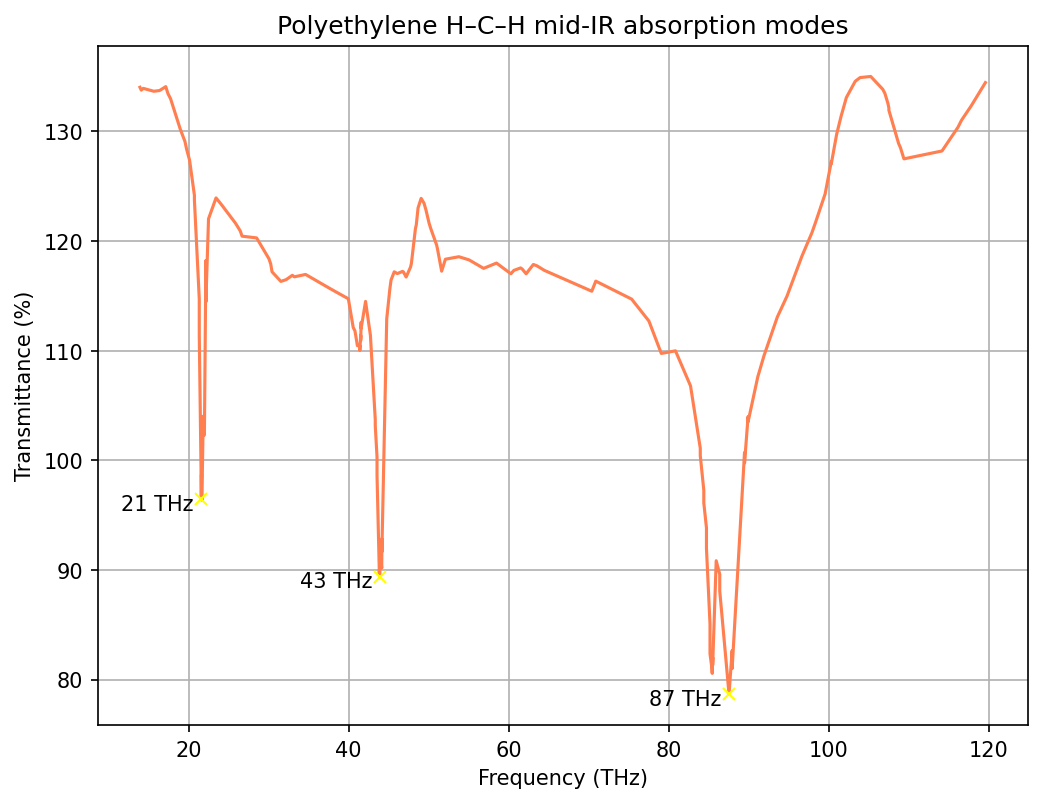

In [ ]:
folder_path = '/content/drive/My Drive/BREAD Experiment/Data Taking/'
PEW = pd.read_csv(folder_path + "PEW_peaks.csv", header=None, usecols=[0,1])
wavenumber = PEW[0]
transmittance = PEW[1]

# Text size
txtsize = 15

c_cm_per_second = 3e10
freqency_PEW = [k*c_cm_per_second*Hz_to_THz  for k in wavenumber]
peaks_index, _ = find_peaks([-1*t for t in transmittance], height=(-115, -70), distance=10)
bad_peaks = [1, 2, 3, 5, 6, 7, 9]
good_peaks = [i for j, i in enumerate(peaks_index) if j not in bad_peaks]
peaks_index = good_peaks

frequencies_of_peaks = np.array(freqency_PEW)[peaks_index]
print("the peaks appear to happen at frequencies: ", frequencies_of_peaks)
# transmittance = transmittance + (95 - max(transmittance)) #shift transmittance so 100% is the maximum

fig = plt.figure(figsize=(8, 6), dpi=150) 
plt.plot(freqency_PEW, transmittance, color = "coral")
plt.plot(np.array(freqency_PEW)[peaks_index], np.array(transmittance)[peaks_index], "x", color = 'yellow')

for x in frequencies_of_peaks:
  plt.text(x-10, np.interp(x,freqency_PEW ,transmittance) - 1, str(int(x)) + " THz")
  
title = "Polyethylene H–C–H mid-IR absorption modes"
plt.title(title)
plt.grid(True)
plt.xlabel("Frequency (THz)")
plt.ylabel("Transmittance (%)")

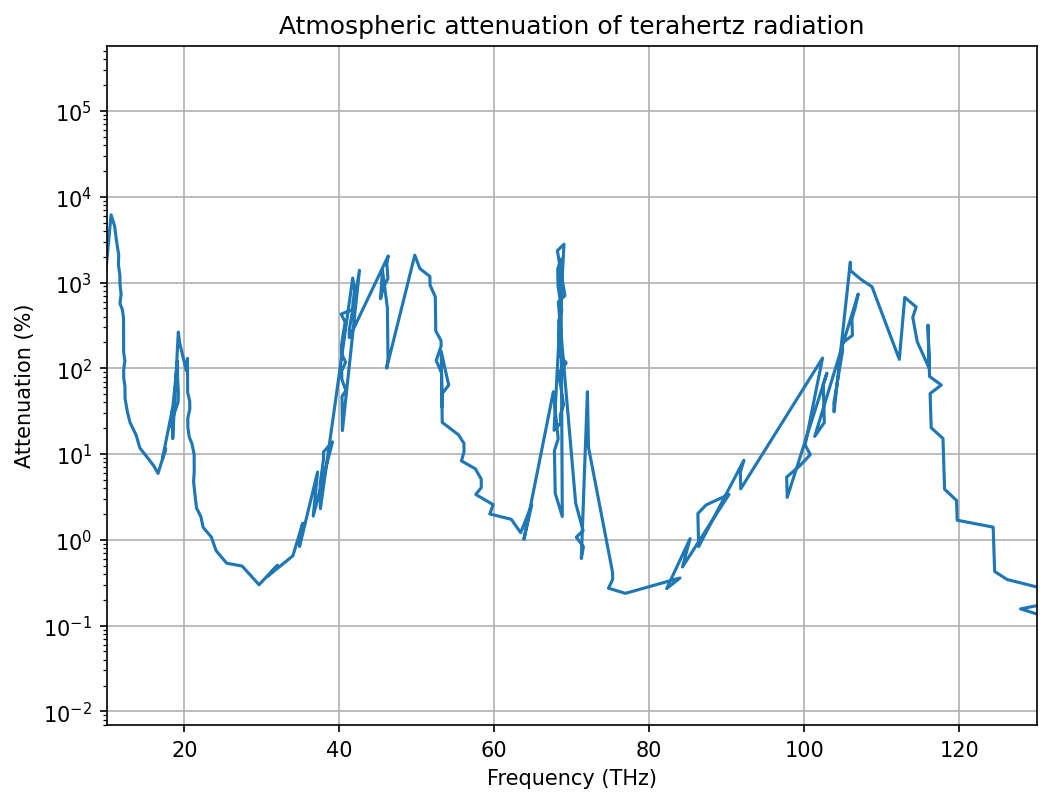

In [ ]:
folder_path = '/content/drive/My Drive/BREAD Experiment/Data Taking/'
atomsphere = pd.read_csv(folder_path + "atomsphere_peaks.csv", header=None, usecols=[0,1])
frequency_GHZ = atomsphere[0]
frequency_attenuation = frequency_GHZ/1000 #this is terahertz
attenuation_dB_per_km = atomsphere[1]

fig = plt.figure(figsize=(8, 6), dpi=150) 
plt.plot(frequency_attenuation, attenuation_dB_per_km)
plt.yscale('log')
plt.title("Atmospheric attenuation of terahertz radiation")
plt.grid(True)
plt.xlabel("Frequency (THz)")
plt.ylabel("Attenuation (%)")
plt.xlim(10, 130)
# plt.ylim(1e-15, 5e-8)
plt.show()

interpolated_attenuation = interp1d(frequency_attenuation, attenuation_dB_per_km, fill_value='extrapolate')

(0.0, 500.0)

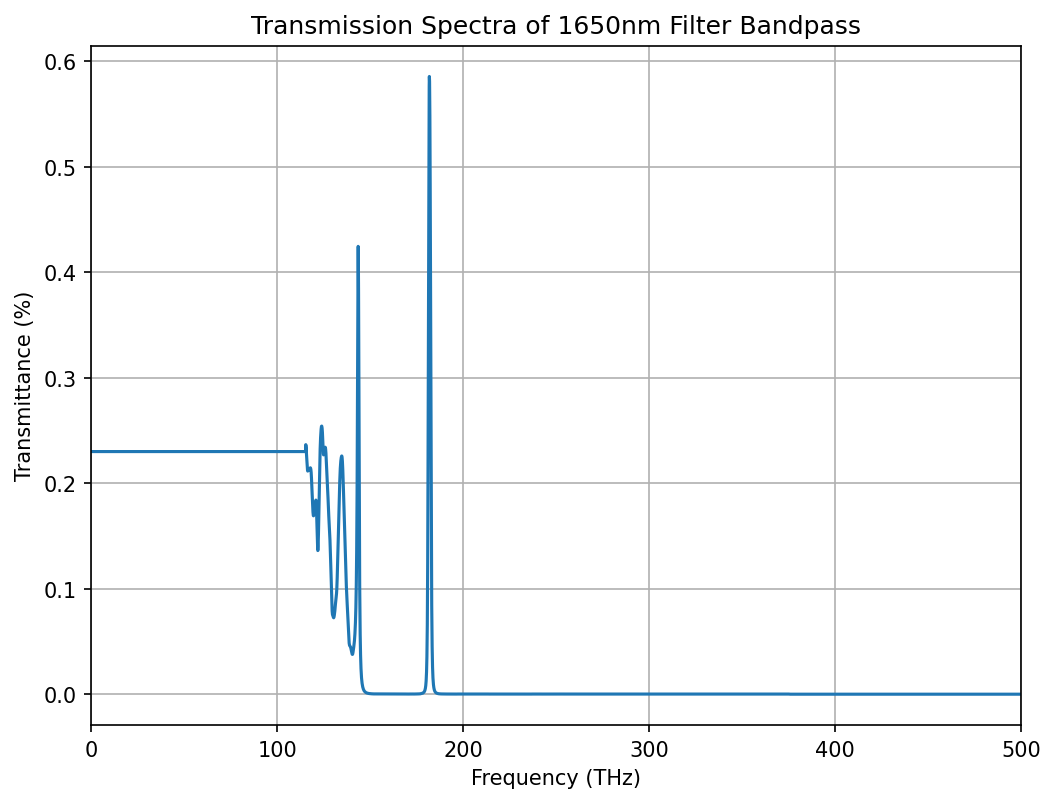

In [ ]:
filter_transmission_1650 = pd.read_csv("/content/drive/My Drive/BREAD Experiment/FTS Modeling/lib/FB1650-12.csv")
cleanedwavelengths_1650 = [x*nm_to_micron for x in filter_transmission_1650['Wavelength (nm)'] if str(x) != 'nan']
cleanedtransmissions_1650 = [x/100 for x in filter_transmission_1650['% Transmission'] if str(x) != 'nan']
interpolate_transmission_1650 = interp1d(cleanedwavelengths_1650,cleanedtransmissions_1650, fill_value=(0,0.23), bounds_error=False) #convert the corresponding wavelengths from nm to micron
transmission_1650nm = interpolate_transmission_1650(Hz_to_THz*c_micron_per_second/frequencies)

fig = plt.figure(figsize=(8, 6), dpi=150)
plt.plot(frequencies, transmission_1650nm)
title = "Transmission Spectra of 1650nm Filter Bandpass"
plt.title(title)
plt.grid(True)
plt.xlabel("Frequency (THz)")
plt.ylabel("Transmittance (%)")
plt.xlim(0, 500)

(0.009, 23.3)

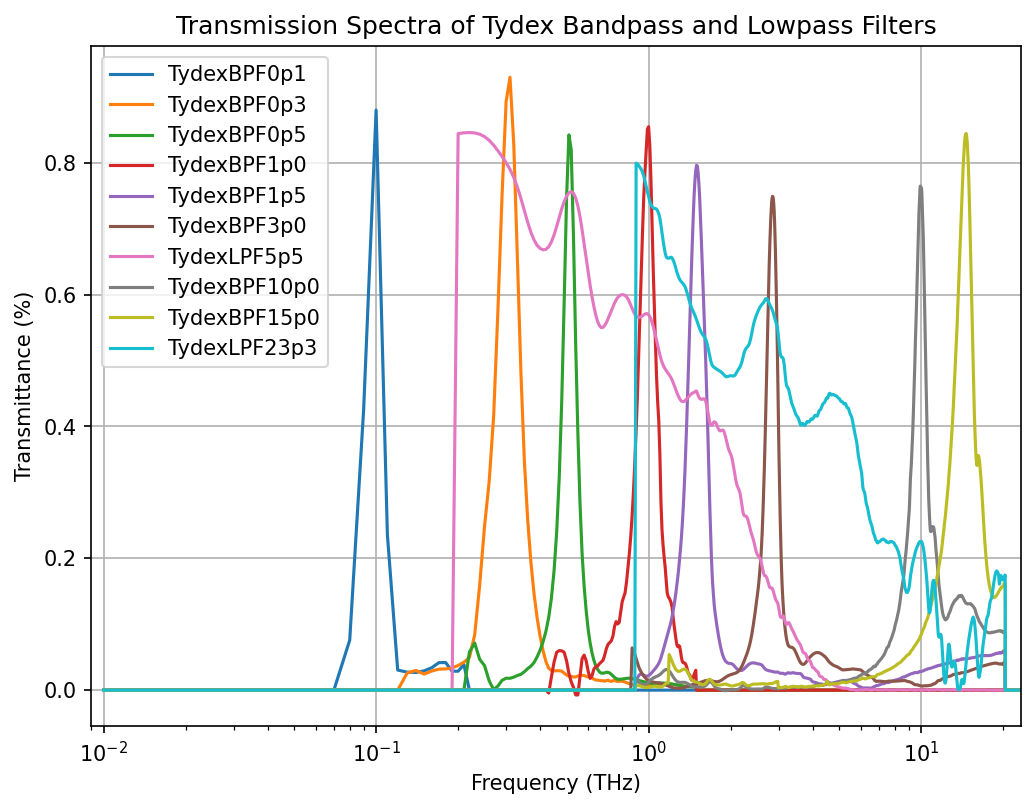

In [ ]:
path = "/content/drive/My Drive/BREAD Experiment/FTS Modeling/lib/TydexFilters/"
bandpasses = ["TydexBPF0p1", "TydexBPF0p3", "TydexBPF0p5", "TydexBPF1p0", "TydexBPF1p5", "TydexBPF3p0", "TydexLPF5p5", "TydexBPF10p0", "TydexBPF15p0", "TydexLPF23p3"]
tydex_transmission = {"TydexBPF0p1": [], "TydexBPF0p3":[], "TydexBPF0p5":[], "TydexBPF1p0":[], "TydexBPF1p5":[], "TydexBPF3p0":[], "TydexLPF5p5":[], "TydexBPF10p0":[], "TydexBPF15p0":[], "TydexLPF23p3":[]}

fig = plt.figure(figsize=(8, 6), dpi=150)
for b in bandpasses:
  transmission = pd.read_csv(path + b + ".csv")
  cleanedwave = [x for x in transmission['Wavelength (um)'] if str(x) != 'nan']
  cleanedtrans = [x for x in transmission["Transmission"] if str(x) != 'nan']
  interpolate_trans  = interp1d(cleanedwave, cleanedtrans, fill_value=(0,0), bounds_error=False) #convert the corresponding wavelengths from nm to micron
  transmission = interpolate_trans(Hz_to_THz*c_micron_per_second/frequencies)
  tydex_transmission[b].append(transmission)
  plt.plot(frequencies, tydex_transmission[b][0], label = b)
title = "Transmission Spectra of Tydex Bandpass and Lowpass Filters"
plt.title(title)
plt.grid(True)
plt.xscale('log')
plt.xlabel("Frequency (THz)")
plt.ylabel("Transmittance (%)")
plt.legend() 
plt.xlim(0.009, 23.3)

In [ ]:
folder_path = '/content/drive/My Drive/BREAD Experiment/Data Taking/Autumn2020Data_NewPowerSupply/'
sys.path.append(folder_path)
from list_of_files import *

In [ ]:
## extract information from file according to name:
def get_file_parameters(f):  
  # Read in CSV file
  df = pd.read_csv(folder_path + 'data/' + f + '.csv', header=None, usecols=[0,1])
  df.dropna(inplace=True)

  # Make legend name from file name
  fi = f.split('-')
  source = fi[3]

  if source == "Laser": voltage, current = 0, 0
  elif source == "Off": voltage, current = 0, 0
  elif source == "M360": voltage, current = float(fi[5].replace('p', '.').replace('C', '')), 0
  else:
    voltage = float(fi[4].replace('p', '.').replace('V', ''))
    current = fi[5].replace('p', '.')
  motion  = fi[7].replace('nmPerSeconds', ' nm/s, ').replace('p', '.').replace('.csv', '')
  source = fi[3]
  filter  = fi[6]
  date = fi[0].replace('data/', '')
  time = fi[1]
  source = '{0}-{1}'.format(fi[2], fi[3])

  if filter == "1650nmFilter": filter = "1650nmBandpassFilter" # fix small error in one filter naming process! 
  if "No" in filter: filter = filter.replace('No', '~no')
  if "Triggered" in filter: filter = "Triggered" + filter.replace('Triggered', '')  #make so filter name ends with word Filter
  case = '{0}_{1}: {2} {3} ({4}V, {5}, {6}) '.format(date, time, source, filter, str(voltage), current,  motion)
  
  # mirror_velocity_adjustment = 1.015
  mirror_velocity_adjustment = 1
  mirrorVelocity = float(fi[7].split('nm')[0])*mirror_velocity_adjustment
  timeToSpace = float(mirrorVelocity) / 1000 # convert seconds to mirror displacement (100 nm / s)

#################
  #speed_adjustment = 0.986 #time to space adjusted according to laser
  speed_adjustment = 0.981 #time to space adjusted according to 1650nm narrowband filter
#################
 
  c  = 3 * (10 ** 17)  # Speed of light in nm / s
  Rs = 5               # Detector sampling rate
  vm = float(mirrorVelocity)*speed_adjustment # Mirror velocity in nm / s (extract from file name)

  if source == 'Mikron-M360':  #the power values for the mikron source are too  low to cut out low powers manually like we normally do
    x = df[0] * timeToSpace
    y = df[1]
  else:
    non_zero_index = [i for i, e in enumerate(df[1]) if e > 2e-6] #this is the list of indexs that give non zero power values
    x = df[0][non_zero_index] * timeToSpace
    y = df[1][non_zero_index]
  
  runparameters = [source, voltage, current, filter, motion, date, time, vm]
  return x, y, runparameters, case

In [ ]:
all_data  = {}
for f in list_of_files:
  x, y, runparameters, case = get_file_parameters(f)
  all_data.update({case:[x,y,runparameters]})
  # print(case)
voltages = sorted(list({all_data[k][2][1] for k in all_data}))
sources = list({all_data[k][2][0] for k in all_data})
filters = list({all_data[k][2][3] for k in all_data})
print("the sources included in these data are: ", sources)
print("the filters included in these data are: ", filters)

the sources included in these data are:  ['Thorlabs-Laser', 'IR-Si207', 'Source-Off', 'IR-12K', 'Mikron-M360', 'IR-Si253']
the filters included in these data are:  ['ChopSourceShortArmsTydexBPF15p0Filter', 'TydexSiliconBeamsplitterAsFilter', 'PEWFilter', 'ChopSourceShortArmsTydexBPF23p3Filter', 'SiWFilter', 'ChopSourceTydexLPF23p3Filter', 'noFilter', '25micronMeshFilter', 'UncoveredChopperBtwnParabolicMirrorBeamsplitterPlasticBagFilter', '1650nmBandpassFilter', 'parabolicMirrorPlasticBlackBlocked20microWatt', 'TydexBPF15p0Filter', 'TriggeredChopSource~noFilter', 'TydexBPF23p3Filter', 'ChopSourceShorterFTSArmsTydexBPF23p3Filter', 'DoublePlasticBagFilter', 'UncoveredChopperBtwnParabolicMirrorBeamsplitterPEWFilter', 'TydexLPF23p3Filter', 'TydexBPF10p0Filter', 'UncoveredChopperBtwnParabolicMirrorBeamsplitternoFilter', 'OfficeDepotRuledPaperFilter', '1000nmBandpassFilter', 'ChopSourceTydexBPF15p0Filter', 'TydexLPF5p5Filter', 'TydexBPF15p0AndLPF23p3Filter', 'TydexLPF23p3andBPF10p0Filter', 'T

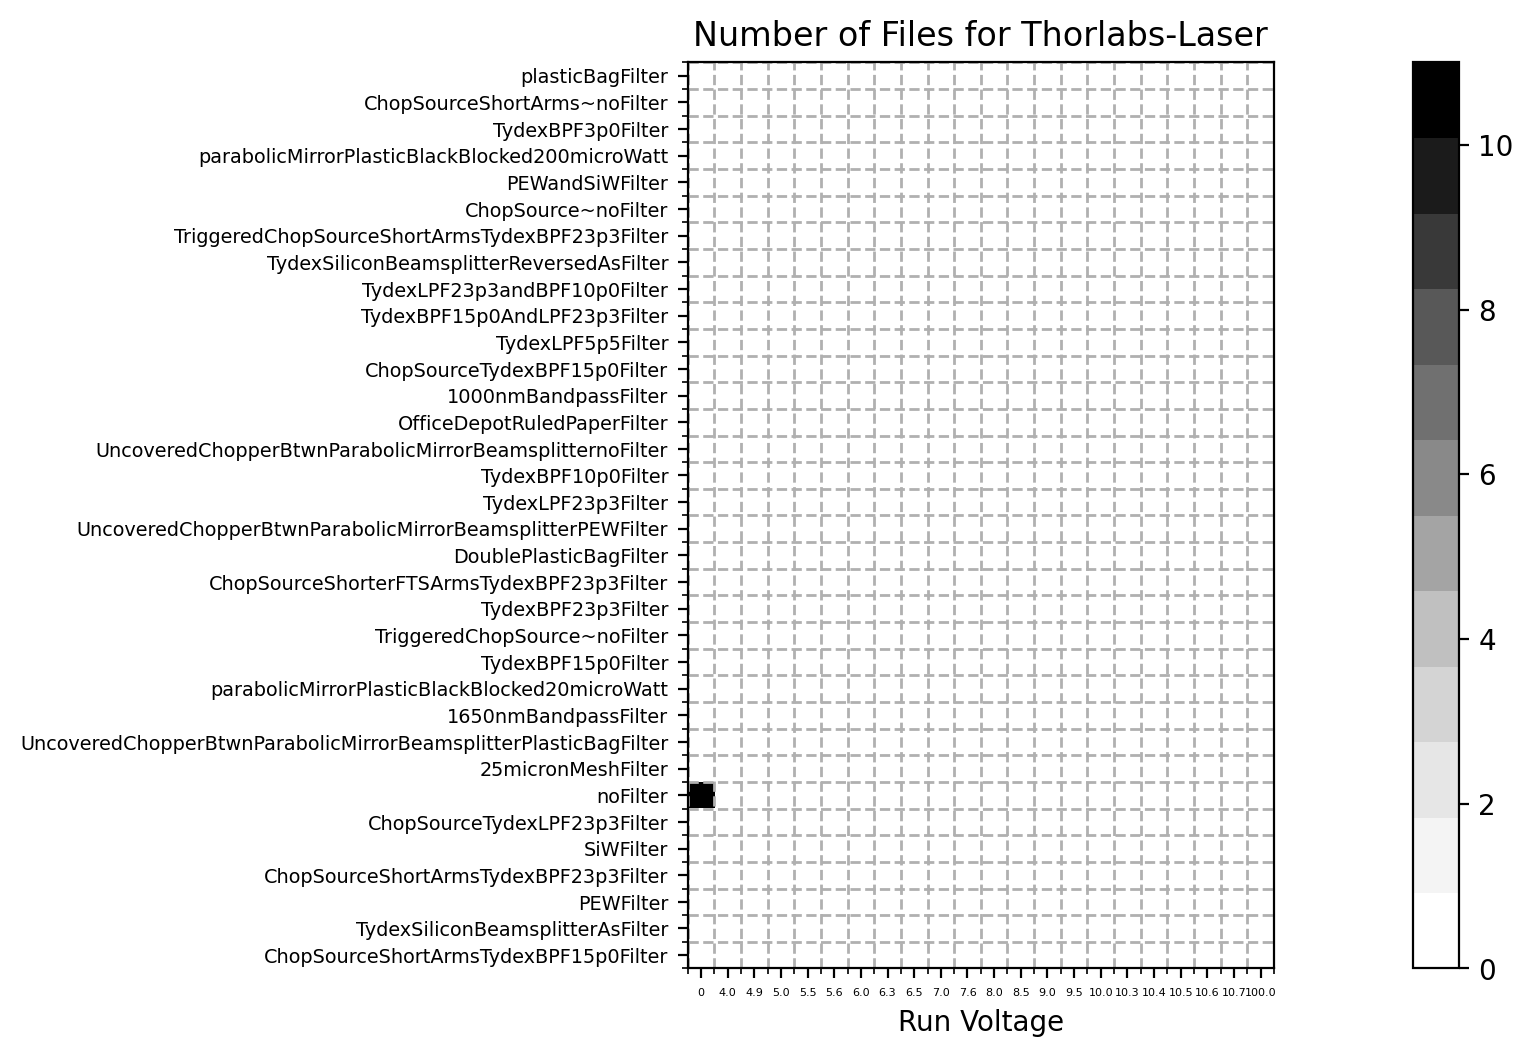

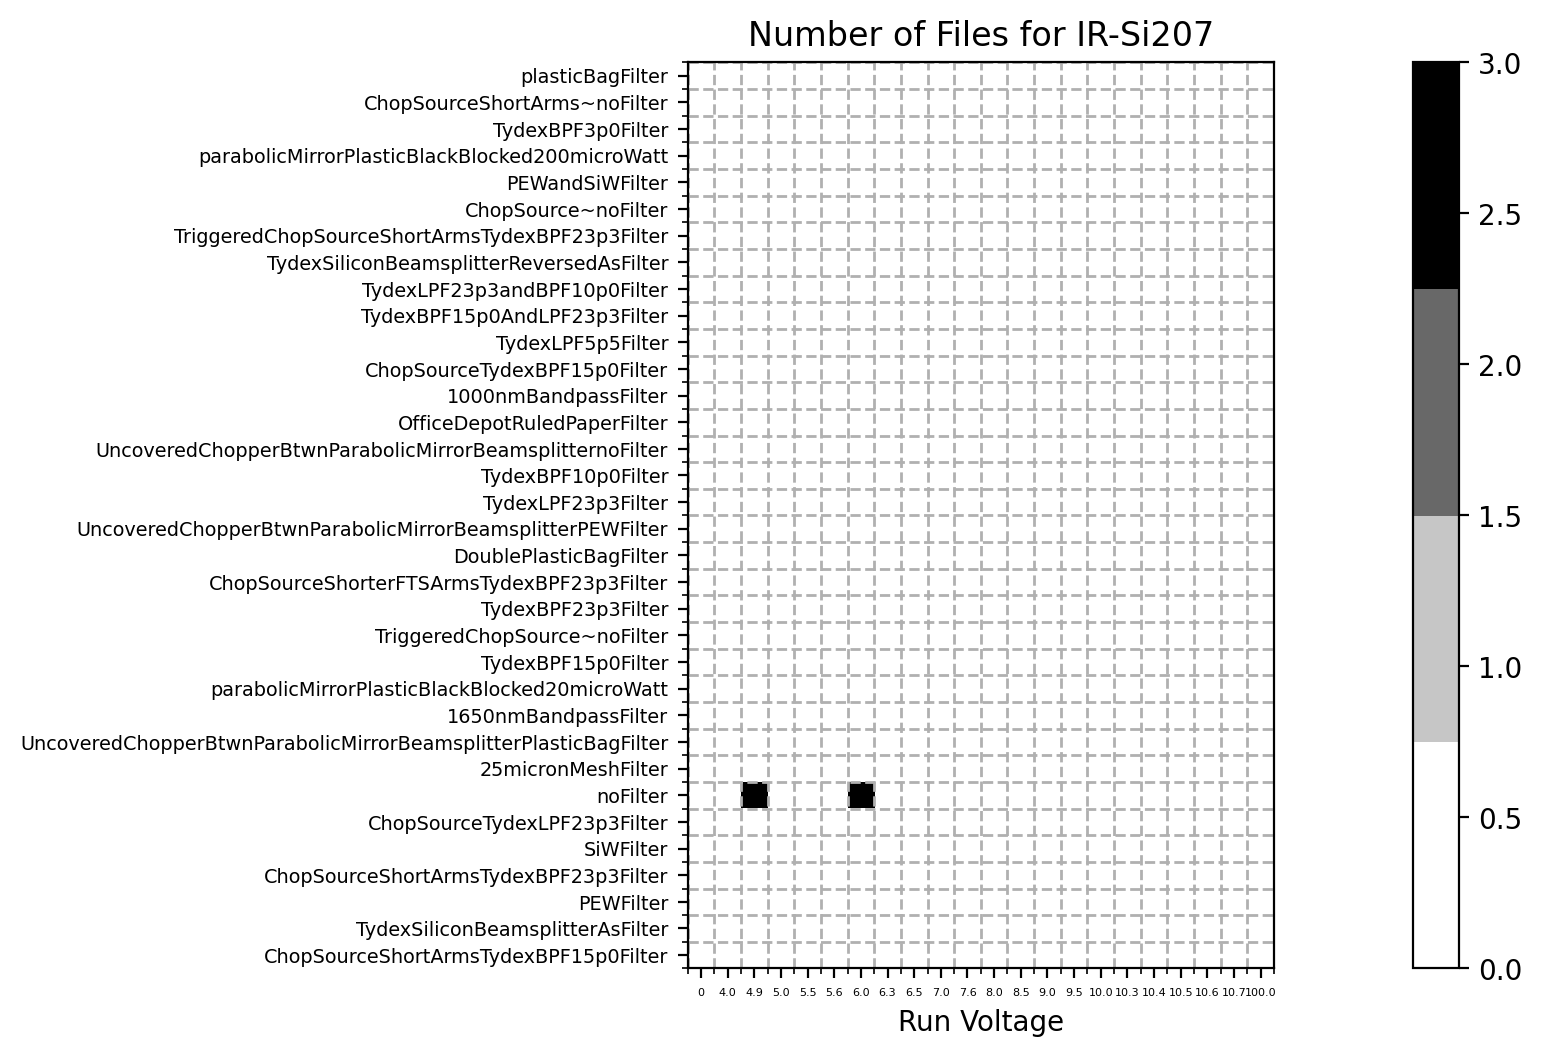

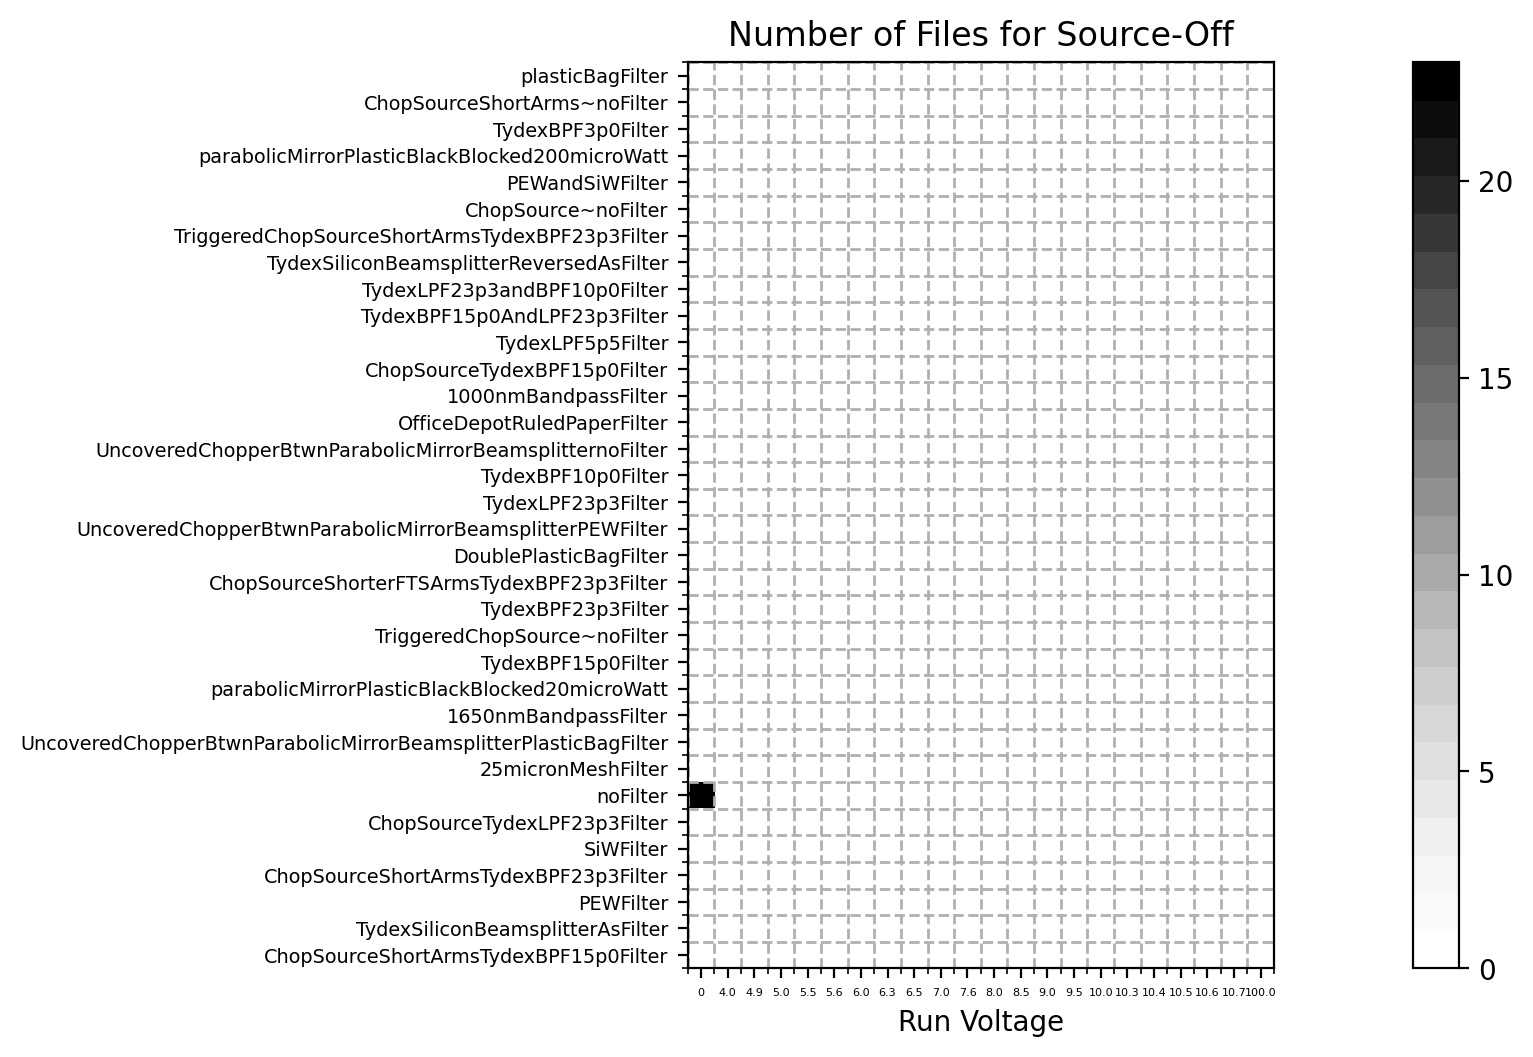

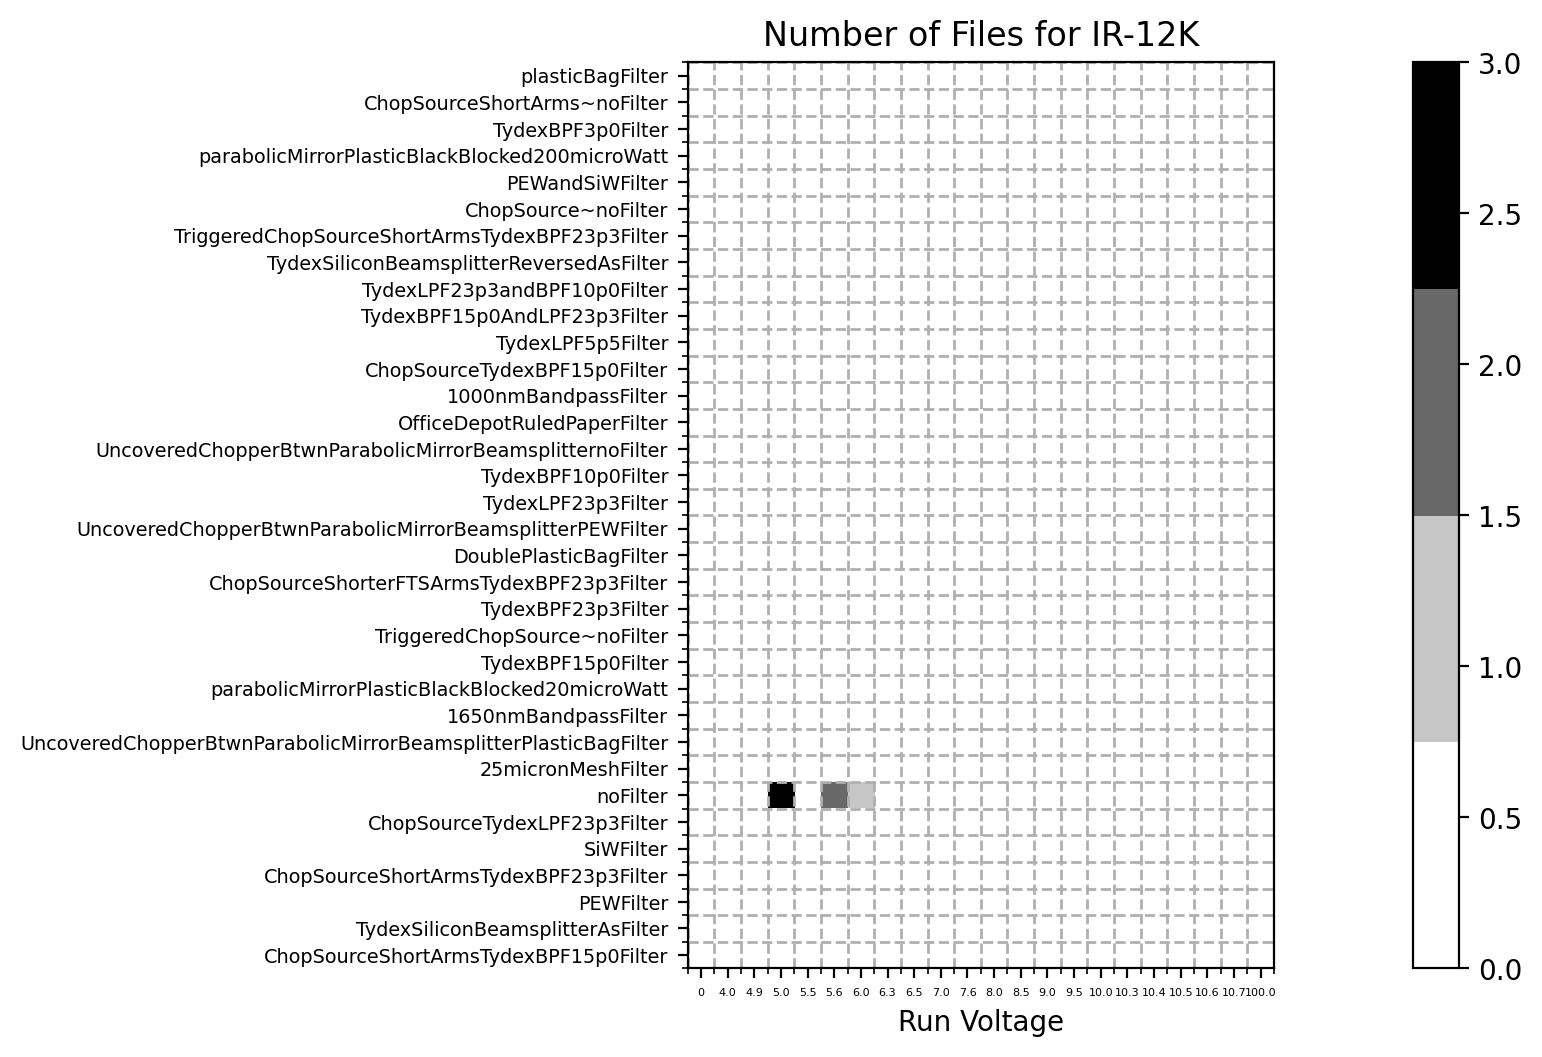

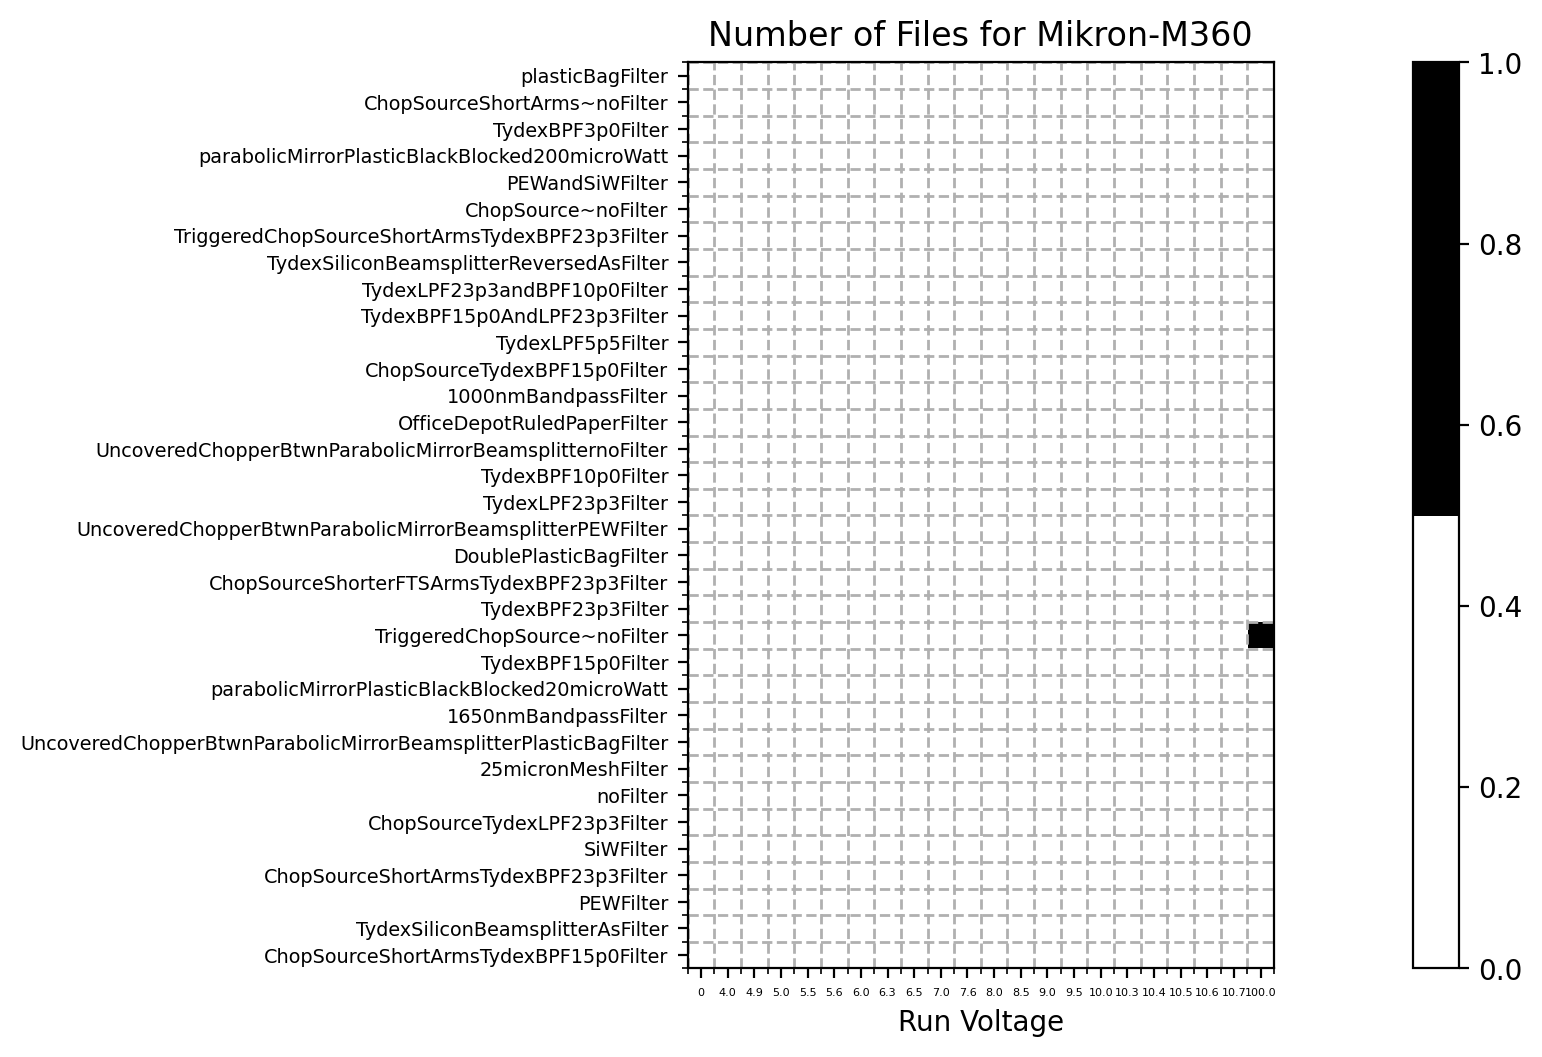

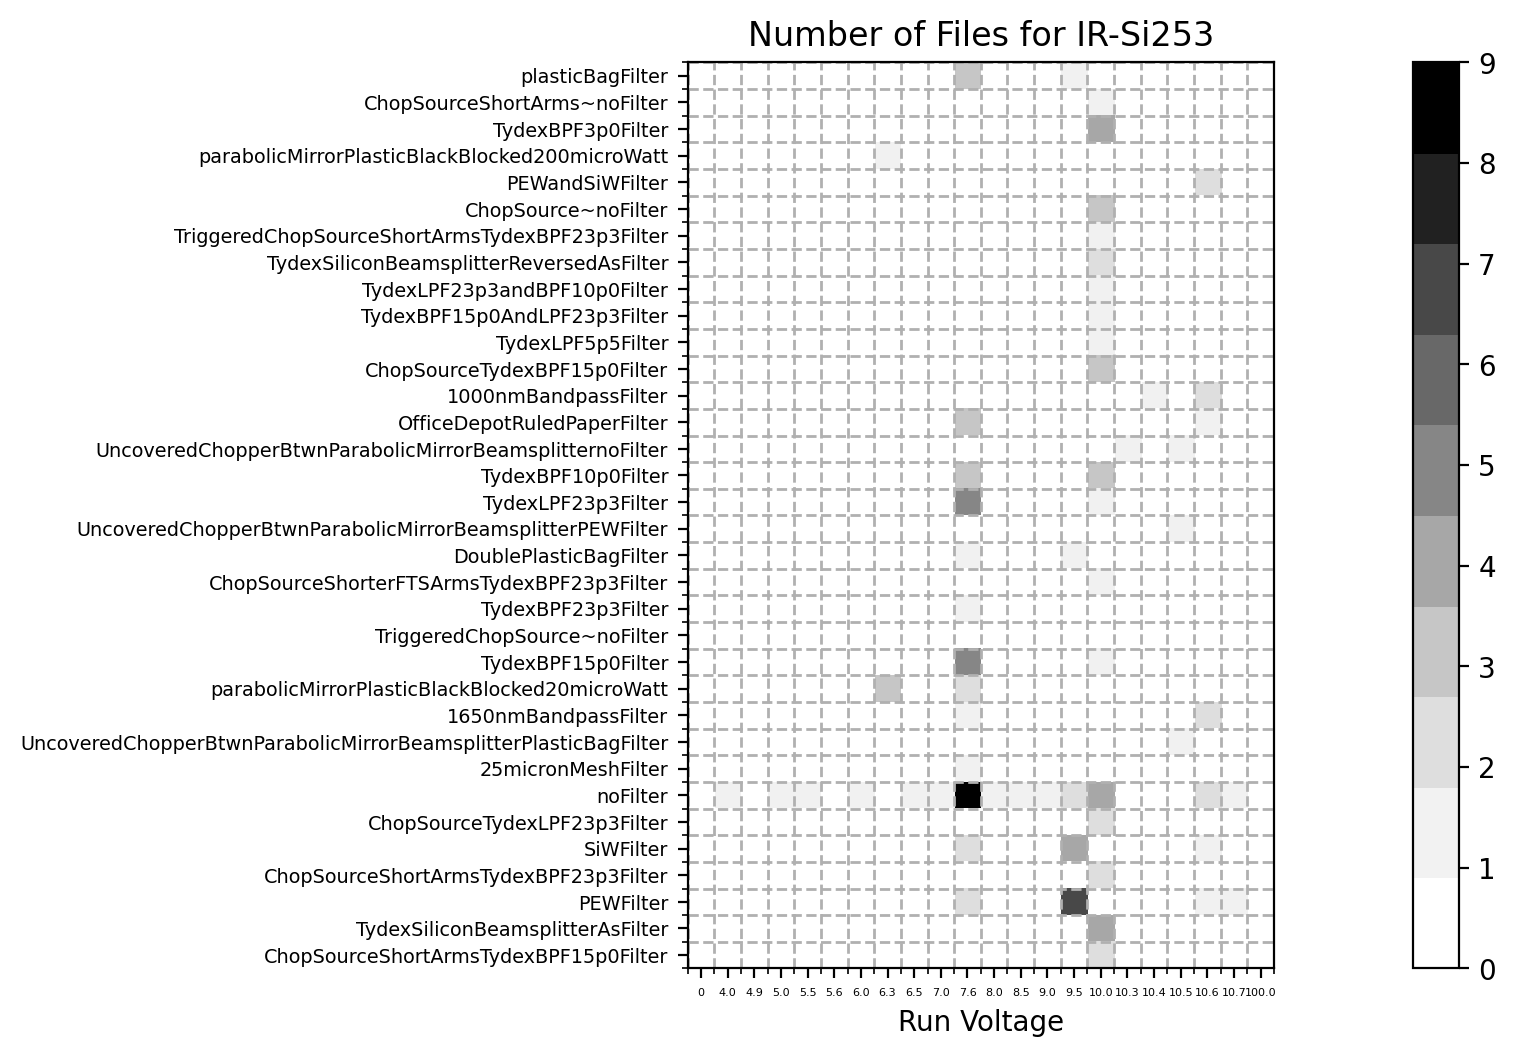

In [ ]:
#generate 2d histograms for each source to get a sense of the data we have taken so far! 
for s in sources:
  count = []
  for f in filters:
    overlap_per_filter = []
    for v in voltages:
      count_num = 0
      for key in all_data:
        if all_data[key][2][0] == s and all_data[key][2][1] == v and all_data[key][2][3] == f: count_num +=1
        
      overlap_per_filter.append(count_num)
    count.append(overlap_per_filter)

  fig = figure(figsize=(18, 6), dpi=200)
  ax = plt.gca()
  cmap = cm.get_cmap("Greys", np.amax(count)+1) 
  imshow(count, origin = "lower", aspect = 1, cmap=cmap) #plots density plot
  colorbar()
  plt.yticks(range(len(filters)), filters, fontsize='x-small') 
  plt.xticks(range(len(voltages)), voltages, fontsize=4)
  plt.title("Number of Files for " + s )
  ax.set_xticks(np.arange(-.5, len(voltages), 1), minor=True)
  ax.set_yticks(np.arange(-.5, len(filters), 1), minor=True)
  ax.grid(linestyle='--', linewidth=1, which='minor')
  plt.xlabel("Run Voltage")

In [ ]:
def generate_simulation(selected_volt, source, filt, for_transmittance=False):
  temp = get_temp(selected_volt, source)
  filter_val = 0
  filter_check = filt + "Filter"
  sigma = noise_to_signal_ratio

  Ls = []
  for key in all_data: 
      if all_data[key][2][1] == selected_volt and all_data[key][2][0] == source and all_data[key][2][3] in filter_check: Ls.append(max(all_data[key][0])) #exctract the length traveled of the first function that has the right voltage and source

  print("length of Ls is", len(Ls))
  if len(Ls) > 0:  dx = -1* max(Ls)/2
  else: print("no files correspond to this voltage, source and filter combination for basing simulation off of")

  if selected_volt == 0: #then this is laser, need to add peak at 635 nm to a room temp blackbody background 
    x, y, weights = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter="no", dx=dx, L=max(Ls), dL=dL,  Temp=293 , sigma=sigma)
    lam = 635 * nm_to_micron 
    k = 1/lam
    laser_scale = 4
    y =  (y + laser_scale*(np.sin(2*pi*k*x)/2.0 + 0.5)) + np.random.rand(len(x))*sigma
  elif for_transmittance: x, y, weights = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter="no", dx=dx, L=max(Ls), dL=dL,  Temp=temp, sigma=sigma)
  elif filt == "PEW" or filt =="SiW": x, y, weights, filter_val = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter=filt, dx=dx, L=max(Ls), dL=dL,  Temp=temp, sigma=sigma)
  elif filt == "1650nmBandpass": x, y, weights, filter_val = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter="narrow_1650", dx=dx, L=max(Ls), dL=dL,  Temp=temp, sigma=sigma)
  elif filt == "1000nmBandpass": x, y, weights, filter_val = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter="narrow_1000", dx=dx, L=max(Ls), dL=dL,  Temp=temp, sigma=sigma)
  else: x, y, weights = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter="no", dx=dx, L=max(Ls), dL=dL,  Temp=temp, sigma=sigma)

  avg_y = sum(y)/len(y)
  
  possible_power_values = np.linspace(0, 50 * avg_y , 4096)
  digitized = np.digitize(y, possible_power_values)
  y_12bit_adjusted = possible_power_values[digitized-1]
  frequency, spectrum = psd_frequency(y_12bit_adjusted, 'parzen')
  
  transmittance_from_attenuation = [10**(-a/100) for a in interpolated_attenuation(frequency)]
  spectrum_adjusted_attenuation = spectrum*transmittance_from_attenuation


  return [x, y_12bit_adjusted, frequency, spectrum, filter_val]
  # return [x, y_12bit_adjusted, frequency, spectrum_adjusted_attenuation, filter_val]

In [ ]:
def normalize(x, y):
  print(frequencies)
  if len(y) == len(frequencies): 
    for i in range(len(x)):
      if abs(x[i]-10) < 1e-4: index_low = i
      elif abs(x[i]-100) < 1e-4: index_high = i
    short_y = y[index_low:index_high]
    normalized_y = y/max(short_y)
  else:
    normalized_y = y/max(y)
  return normalized_y

In [ ]:
def gaussian(x, height, center, width, offset):
    return height*np.exp(-(x - center)**2/(2*width**2)) + offset
def three_gaussians(x, h1, c1, w1, h2, c2, w2, h3, c3, w3, offset):
    return (gaussian(x, h1, c1, w1, offset=0) +
        gaussian(x, h2, c2, w2, offset=0) +
        gaussian(x, h3, c3, w3, offset=0) + offset)
def four_gaussians(x, h1, c1, w1, h2, c2, w2, h3, c3, w3, h4, c4, w4, offset):
  return (gaussian(x, h1, c1, w1, offset=0) +
        gaussian(x, h2, c2, w2, offset=0) +
        gaussian(x, h3, c3, w3, offset=0) + 
        gaussian(x, h4, c4, w4, offset=0) + offset)

In [ ]:
def plot_transmittance(plot_simulation, frequency_array, averages, selected_volt, source, filt, simulated, k=1):
  fig, ax = plt.subplots(figsize=(12,6), dpi=100)

  if plot_simulation and ("no" in filt):  #then compare the "filter" as data, and "no filter" as simulation
    title = "Transmission of data vs simulation as a function of Frequency"
    average_spectrum, num_avg = averages[0][0], averages[0][1]
    simulated_frequency, simulated_spectrum = simulated[2], simulated[3]
    interpolated_simulation = interp1d(simulated_frequency, simulated_spectrum, fill_value='extrapolate')
    ratio =  np.array(average_spectrum)/np.array(interpolated_simulation(frequency_array))
    plt.plot(frequency_array, ratio, label = "Bandpass of data to simulation (averaged over " + str(num_avg) + " filter trials)", color='C9')
  elif "no" in filt: return
  
  else: 
    # title = filt + " Filter Bandpass as a function of Frequency"
    if filt == "plasticBag": title = "Filter: Polyethylene bag, 1 layer"
    elif filt == "DoublePlasticBag": title = "Filter: Polyethylene bag, 2 layers"
    elif filt == "1650nmBandpass": title = "Filter: 1650nm bandpass"
    elif filt in bandpasses: 
      nums = re.findall('[0-9]+', filt)
      title = str(nums[0]) +  "." + str(nums[1]) + " THz " + filt[5] +"PF"
    else: title = "Filter: "  + filt
    
    average_spectrum_filter, num_avg_filter = averages[0][0], averages[0][1]
    average_spectrum_nofilter, num_avg_nofilter = averages[1][0], averages[1][1]
    ratio =  np.array(average_spectrum_filter)/np.array(average_spectrum_nofilter)
    ratio_peaks_data, _ = find_peaks([-1*t for t in ratio], height=(-0.3, 0))
    peak_frequencies_repeat = [int(frequency_array[x]) for x in ratio_peaks_data if 10.0 <= frequency_array[x] <= 130.0]
    peak_frequencies = set(peak_frequencies_repeat)


    if filt == "PEW" or filt == "plasticBag" or filt == "DoublePlasticBag":
      modified_transmittance = [10 ** (k * np.log10(t)) for t in transmittance]
      normalized_ratio = normalize(frequency_array, ratio)
      normalized_peaks = normalize(freqency_PEW, modified_transmittance)
      
      #gaussian fit stuff
      sf = np.where(abs(frequency_array-10)<= 0.1)[0][0]
      bf = np.where(abs(frequency_array-100)<= 0.1)[0][0]
      errfunc = lambda p, x, y: (four_gaussians(x, *p) - y)**2
      guess = [0.1, 21, 0.1, 0.1, 43, 0.2, 1, 50, 1, 0, 87, 2, 0]  #3 peaks (y, x, spread) guesses and offset
      optim, success = optimize.leastsq(errfunc, guess[:], args=(frequency_array[sf:bf], normalized_ratio[sf:bf]))
      fit_str = "Fit data to Gaussian: (mean, FWHM) = (" + str(round(optim[1],1)) + ", " + str(round(2 * sqrt(2 *np.log(2)) * abs(optim[2]),1)) +  ") , (" + str(round(optim[4],1)) + " , " + str(round(2 * sqrt(2 *np.log(2)) * abs(optim[5]),1)) +  ") , (" + str(round(optim[7],1)) + ", " + str(round(2 * sqrt(2 *np.log(2)) * abs(optim[8]),1)) +  "), (" + str(round(optim[10],1)) + ", " + str(round(2 * sqrt(2 *np.log(2)) * abs(optim[11]),1)) +  ") THz"
      
      plt.plot(frequency_array, four_gaussians(frequency_array, *optim),linewidth=5.0, alpha = 0.3, c='royalblue', label=fit_str )
      plt.plot(frequency_array, normalized_ratio, label = "Filter bandpass data (averaged over " + str(num_avg_filter) + " filter trials)", color='C9')
      plt.plot(freqency_PEW, normalized_peaks, label = "Polyethylene spectrum from Polym. Test. 31 (2012) 1094-1099, k="+str(k), color = "coral")
      # for x in peak_frequencies: plt.text(x, np.interp(x, frequency_array, normalized_ratio), str(x) + " THz", fontsize='xx-small')
      if filt == "DoublePlasticBag":
        ax.text(12, -0.06, title, fontsize=txtsize*1.2)
        plt.xlim(10, 130)
        plt.ylim(-0.1, 1.35)
      else:
        ax.text(12, 0.04, title, fontsize=txtsize*1.2)
        plt.xlim(10, 130)
        plt.ylim(0, 1.35)

    elif filt == "1650nmBandpass": 
      #gaussian fit stuff
      errfunc = lambda p, x, y: (gaussian(x, *p) - y)**2
      sf = np.where(abs(frequency_array-140)<= 0.1)[0][0]
      bf = np.where(abs(frequency_array-200)<= 0.1)[0][0]
      guess = [0.5, 181.6, 0.3, 0] 
      optim, success = optimize.leastsq(errfunc, guess[:], args=(frequency_array[sf:bf], ratio[sf:bf]))
      fit_str = "Fit data to Gaussian: (mean, FWHM) = (" + str(round(optim[1],1)) + ", " + str(round(2 * sqrt(2 *np.log(2)) * abs(optim[2]),1)) +  ")THz"

      plt.plot(frequency_array, gaussian(frequency_array, *optim), linewidth=5.0, alpha = 0.3, c='royalblue',label=fit_str )
      plt.plot(frequency_array, ratio, label = "Filter bandpass data (averaged over " + str(num_avg_filter) + " filter trials)", color='C9')
      plt.plot(frequencies, transmission_1650nm, label = "Transmission spectrum of 1650nm filter bandpass", color = "coral")
      
      plt.xlim(115, 220)
      ax.text(117,-0.06, title, fontsize=txtsize*1.2)
      plt.ylim(-0.1, 0.8)

    elif filt in bandpasses:
      plt.plot(frequency_array, ratio, label = "Filter bandpass data (averaged over " + str(num_avg_filter) + " filter trials)", color='C9')
      plt.plot(frequencies, tydex_transmission[filt][0], label = "Transmission spectrum of " + title , color = "coral")
      plt.xlim(0, 23)
      plt.ylim(-0.1, 1)
      ax.text(0.0, -0.08, title, fontsize=txtsize*1.2)

    else: 
      plt.plot(frequency_array, ratio, label = "Filter bandpass data (averaged over " + str(num_avg_filter) + " filter trials)", color='C9')
      plt.xlim(10, 200)
      ax.text(11, 0.04, title, fontsize=txtsize*1.2)
      plt.ylim(0, 1.2)

  # plt.title(title)
  # plt.grid(True)
  plt.legend(frameon=False, fontsize=txtsize*0.9)
  
  plt.xlabel('Frequency [THz]', fontsize=24, labelpad=12)
  plt.ylabel('Transmission', fontsize=24, labelpad=12)
  ax.tick_params('both', length=12, width=1, which='major', labelsize=20, pad=10)
  ax.tick_params('both', length=6,  width=1, which='minor') 
  ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
  plt.subplots_adjust(left=0.15, right=0.97, top=0.95, bottom=0.2)
  return

In [ ]:
def plot_details(selected_volt, source, filt, simulated):

  filter_check = filt + "Filter"
  temp = get_temp(selected_volt, source)
  plot_two = False #determines if we care to plot the input data and the output spectrum or just the spectrum

  if plot_two:
    fig = plt.figure(figsize=(23, 6), dpi=150)
    plt.subplot(1, 2, 1)
  else: 
    fig, ax = plt.subplots(figsize=(12,8))

  if len(simulated) > 0: 
      plot_simulation = True
      x_simulated, y_simulated, frequency_simulated, spectrum_simulated, filter_val = simulated[0], simulated[1], simulated[2], simulated[3], simulated[4]  
  else: plot_simulation = False
  for key in all_data:
    if plot_two and all_data[key][2][1] == selected_volt and all_data[key][2][0] == source and all_data[key][2][3]==filter_check: plt.plot(all_data[key][0], all_data[key][1], label = all_data[key][2][5] + "_" + all_data[key][2][6] + ": " + all_data[key][2][4])
  if plot_two: plt.subplot(1,2,2)
  count = 0
  for key in all_data:
    if all_data[key][2][1] == selected_volt and all_data[key][2][0] == source and all_data[key][2][3]==filter_check:
      count += 1
      if "1650nm" in key: plt.axvline(x=181.6, color = 'yellow')
      elif "1000nm" in key: plt.axvline(x=299.7, color = 'yellow')
      frequency, spectrum = psd_frequency_vm(all_data[key][1], 'parzen', vm=all_data[key][2][7])
      if count == 1: plt.plot(frequency, spectrum*1e6, label = all_data[key][2][0] + " with " + filt + " filter") #we only want to add a legend label to the first entry element 
      else: plt.plot(frequency, spectrum*1e6)
  if plot_simulation: plt.plot(frequency_simulated, spectrum_simulated*1e6, '--' ,label = "Simulated")
  
  plt.xscale('log')
  plt.yscale('log')

  if plot_two: #plot details of both the signal and spectrum plot
    #plot details for blackbody spectrum plot
    plt.subplot(1, 2, 1)
    plt.grid(True)
    title = source + " at " + str(int(temp)) + "K Interferometer Signal with " + filt + " filter"
    plt.title(title)
    plt.legend(fontsize='xx-small')
    plt.yscale('log')
    plt.xlabel("Optical path difference ($\mu m$)")
    ##plot details for the output spectrum 
    plt.subplot(1, 2, 2)
    title = "Transform of interferometer signal for " + source + " at " + str(int(temp)) + "K with " + filt + " filter"
    plt.title(title)
    plt.legend(fontsize='xx-small')
    plt.grid(True)
    plt.xlabel('Frequency (THz)')
    plt.ylabel("Power Density[$\mu$W/THz$^{-1/2}$]")

  else: #only plot the spectrum
    plt.xlabel('Frequency [THz]', fontsize=24, labelpad=12)
    plt.ylabel('Spectral density [$\mu$W THz$^{-1/2}$]', fontsize=24, labelpad=12)
    ax.tick_params('both', length=12, width=1, which='major', labelsize=20, pad=10)
    ax.tick_params('both', length=6,  width=1, which='minor') 
    ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 200, 500])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.subplots_adjust(left=0.15, right=0.97, top=0.95, bottom=0.2)
    # plt.legend(frameon=False, fontsize=txtsize)
    plt.legend(frameon=False, fontsize=24)
  
  if source == "Thorlabs-Laser": 
    plt.axvline(x=470, color = 'yellow')
    plt.xlim(200, 800)
    plt.ylim(1e-9, 2e-6)
  elif source == "Mikron-M360":
    plt.ylim(1e-5, 1e-1)
    plt.xlim(1, 500)
  elif filt in bandpasses:
    plt.xlim(1, 500)
    plt.ylim(1e-5, 1e-1)
  else: 
    plt.xlim(1, 500)
    plt.ylim(1e-4, 1e1)

  plt.show()
  return 

In [ ]:
def generate_average_spectrum(frequency_array, selected_volt, source, filt):
  filter_check = filt + "Filter"
  interpolated = []

  for key in all_data:
    if all_data[key][2][1] == selected_volt and all_data[key][2][0] == source and all_data[key][2][3]==filter_check: 
      frequency, spectrum = psd_frequency_vm(all_data[key][1], 'parzen', vm=all_data[key][2][7])
      interpolated_function = interp1d(frequency, spectrum, fill_value='extrapolate')
      interpolated.append(interpolated_function(frequency_array))

  print("the number of boys we are averaging over is:" , len(interpolated))
  if len(interpolated) == 1: average_spectrum = interpolated[0]
  else: average_spectrum = np.average(np.vstack(np.array(interpolated)), axis=0)
    
  return [average_spectrum, len(interpolated)]

In [ ]:
def plot_average(frequency_array, averages, selected_volt, source, filt):
  temp = get_temp(selected_volt, source)
  fig, ax = plt.subplots(figsize=(12,8))
  
  average_spectrum_filter, num_avg_filter = averages[0][0], averages[0][1]
  if "no" not in filt: 
    average_spectrum_nofilter, num_avg_nofilter = averages[1][0], averages[1][1]
    plt.plot(frequency_array, average_spectrum_nofilter*1e6, label = "average for no filter (averaged over " + str(num_avg_nofilter) + " trials)")
 
  if "1650nm" in filt: plt.axvline(x=181.6, color = 'yellow')
  elif "1000nm" in filt: plt.axvline(x=299.7, color = 'yellow')
  
  plt.plot(frequency_array, average_spectrum_filter*1e6, label = "average for " + filt + " filter (averaged over " + str(num_avg_filter) + " trials)")
  if filt == "PEW": 
    simulated = generate_simulation(selected_volt, source, filt, for_transmittance=True)
    interpolated_simulation = interp1d(simulated[2], simulated[3], fill_value='extrapolate')
    simulated[3] = (max(average_spectrum_nofilter[np.where(abs(frequencies - 10)<= 0.1)[0][0]:np.where(abs(frequencies - 200)<= 0.1)[0][0]])/max(simulated[3])) * simulated[3]
    plt.plot(simulated[2], simulated[3]*1e6, "--",label = "Simulated without filter")

  ############## Jesse's edits for aestetics ############
  plt.xlabel('Frequency [THz]', fontsize=24, labelpad=12)
  plt.ylabel('Spectral density [$\mu$W THz$^{-1/2}$]', fontsize=24, labelpad=12)
  ax.tick_params('both', length=12, width=1, which='major', labelsize=20, pad=10)
  ax.tick_params('both', length=6,  width=1, which='minor') 
  ax.set_xticks([0, 50, 100, 150, 200])
  ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
  plt.subplots_adjust(left=0.15, right=0.97, top=0.95, bottom=0.2)
  plt.legend(frameon=False, fontsize=17)
  
  # plt.title("Fourier Transform of " + source + " at "  + str(int(temp)) + "K as a function of Frequency")

  if source == "Thorlabs-Laser": 
    plt.xlim(400, 500)
    plt.axvline(x=470, color = 'yellow')
  elif filt == "1650nmBandpass": 
    plt.xlim(115, 220)
    #plt.ylim(1e-9, 5e-7)
  elif filt in bandpasses:
    plt.xlim(0, 23)
    ax.set_xticks([0, 5, 10, 20])
  else: plt.xlim(10, 200)

  plt.show()
  return 

In [ ]:
def plot_data(selected_volt, source, filt, plot_simulation = True, compare_nofilter = True, bandpass = False, k=1):
  simulated = []
  if plot_simulation:  
    simulated = generate_simulation(selected_volt, source, filt)
  if bandpass or compare_nofilter:
    avgs = []    
    avgs.append(generate_average_spectrum(frequencies, selected_volt, source, filt))
    if "no" not in filt: avgs.append(generate_average_spectrum(frequencies, selected_volt, source, "no"))
  if plot_simulation: #this is normalizing the integral under the simulated transform spectra to the the transform of data
    interpolated_simulation = interp1d(simulated[2], simulated[3], fill_value='extrapolate')
    scaling_factor = (max(avgs[0][0][np.where(abs(frequencies - 10)<= 0.1)[0][0]:np.where(abs(frequencies - 100)<= 0.1)[0][0]])/max(simulated[3]))
    simulated[3] = scaling_factor * simulated[3]
    print(simulated[3]*1e6)
  if bandpass: plot_transmittance(plot_simulation, frequencies, avgs, selected_volt, source, filt, simulated, k)
  if compare_nofilter: plot_average(frequencies, avgs, selected_volt, source, filt)
  
  plot_details(selected_volt, source, filt, simulated)
  return 

the array is  0          0.04
1          0.08
2          0.12
3          0.16
4          0.20
          ...  
14742    589.64
14743    589.68
14744    589.72
14745    589.76
14746    589.80
Name: 0, Length: 14747, dtype: float64
the biggest value is  589.8000000000001
length of Ls is 1
the number of boys we are averaging over is: 1
[3.48096969e-04 9.25970990e-04 2.17140590e-03 ... 1.74998033e-04
 1.10804989e-04 2.17551963e-05]


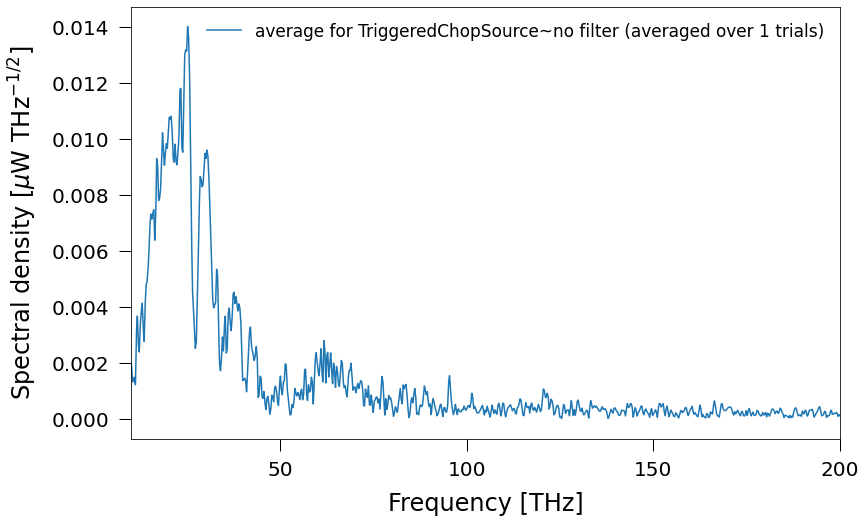

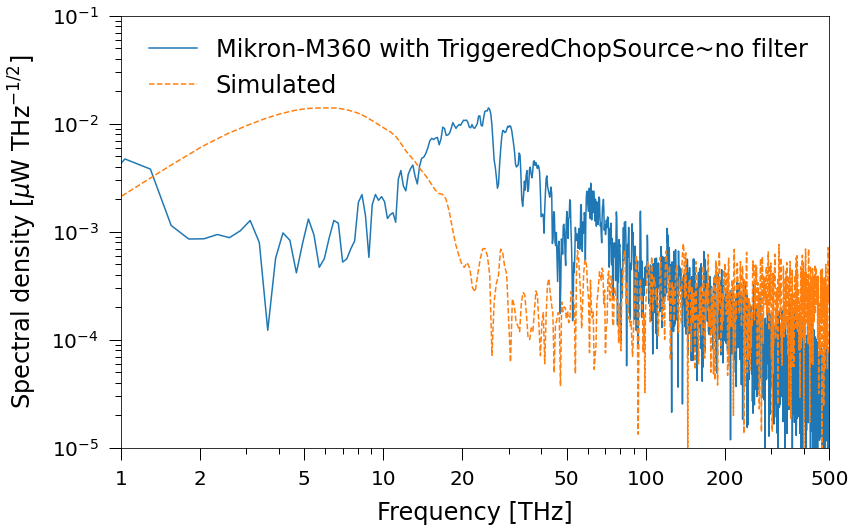

In [ ]:
plot_data(100.0, "Mikron-M360", "TriggeredChopSource~no", plot_simulation = True)

the number of boys we are averaging over is: 4
the number of boys we are averaging over is: 4


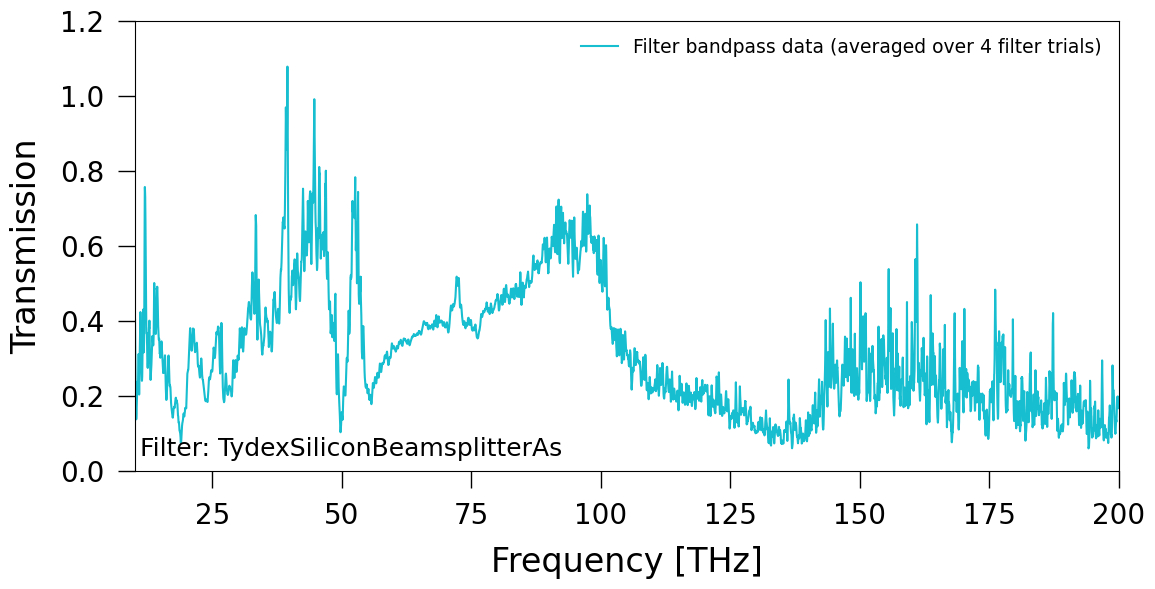

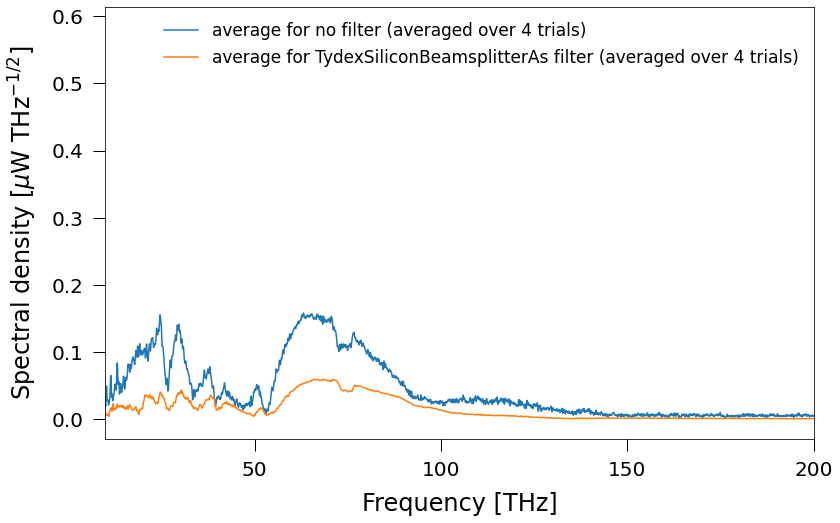

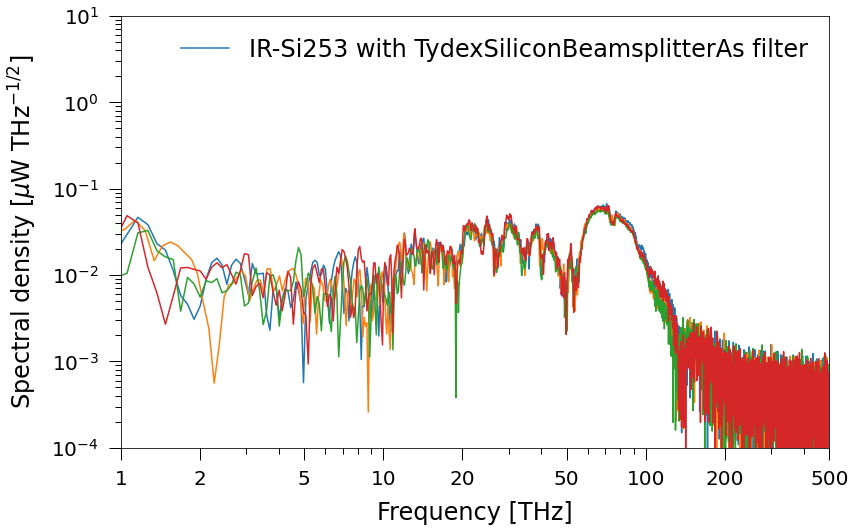

In [ ]:
plot_data(10.0, "IR-Si253", "TydexSiliconBeamsplitterAs", plot_simulation = False, bandpass = True)

In [ ]:
plot_data(7.6, "IR-Si253", "TydexBPF10p0", plot_simulation = False, bandpass = True)

In [ ]:
plot_data(7.6, "IR-Si253", "TydexBPF15p0", plot_simulation = False, bandpass = True)

In [ ]:
plot_data(7.6, "IR-Si253", "TydexLPF23p3", plot_simulation = False, bandpass = True)

In [ ]:
# plot_data(10.6, "IR-Si253", "1650nmBandpass", plot_simulation = False, bandpass = True)

In [ ]:
# plot_data(7.6, "IR-Si253", "PEW", plot_simulation = False, compare_nofilter = True, bandpass = True, k=5.2)

In [ ]:
# plot_data(10.6, "IR-Si253", "PEW", plot_simulation = False, compare_nofilter = True, bandpass = True, k=5.2)

In [ ]:
# plot_data(7.6, "IR-Si253", "plasticBag", plot_simulation = False, bandpass = True, k=2.5)

In [ ]:
# plot_data(7.6, "IR-Si253", "DoublePlasticBag", plot_simulation = False, bandpass = True, k=6)

In [ ]:
# plot_data(7.6, "IR-Si253", "no", plot_simulation = True, compare_nofilter = True, bandpass = True)

In [ ]:
# plot_data(0, "Thorlabs-Laser", 'no', plot_simulation = True, compare_nofilter = True, bandpass = False)

In [ ]:
# plot_data(4.9, "IR-Si207", "no", plot_simulation = True, compare_nofilter = True)

In [ ]:
# plot_data(9.5, "IR-Si253", "PEW", plot_simulation = False, compare_nofilter = True, bandpass = True)

In [ ]:
# plot_data(7.6, "IR-Si253", "SiW", plot_simulation = False, compare_nofilter = True, bandpass = True)

In [ ]:
# plot_data(9.5, "IR-Si253", "SiW", plot_simulation = False, bandpass = True)

In [ ]:
# plot_data(7.6, "IR-Si253", "OfficeDepotRuledPaper", plot_simulation = False, bandpass = True)

In [ ]:
# plot_data(10.6, "IR-Si253", "no", plot_simulation = True, compare_nofilter = True, bandpass = True)